# Day 19 – Smooth Category Time Series

This notebook rebuilds the semantic category featurization with an emphasis on producing smooth, TR-aligned predictors ready for EDM/Simplex/CCM workflows. It:

- regenerates the canonical (≈50 ms) category trajectories for a single subject/story
- applies configurable smoothing in the canonical domain (moving-average or Gaussian)
- re-aggregates the smoothed signal to the scanner TR grid and preserves both raw & smoothed outputs
- optionally aligns to the Day 16 trimmed window for direct use in downstream modelling

Edit the configuration cell to point at your subject/story and smoothing preferences, then run the pipeline cell to materialize CSVs under `features/` and inspect the resulting series.

In [1]:
import json
import math
import os
import sys
import warnings
from collections import Counter
from pathlib import Path
from typing import Any, Dict, List, Optional, Sequence, Tuple

import numpy as np
import pandas as pd

np.random.seed(42)
pd.options.display.max_columns = 60

project_root = Path('/flash/PaoU/seann/fmri-edm-ccm')
project_root.mkdir(parents=True, exist_ok=True)
os.chdir(project_root)

sys.path.append(str(project_root))
sys.path.append('/flash/PaoU/seann/pyEDM/src')
sys.path.append('/flash/PaoU/seann/MDE-main/src')

try:
    import ipywidgets as widgets
    from IPython.display import display
except Exception:
    widgets = None
    def display(obj):
        print(obj)

try:
    import matplotlib.pyplot as plt
except Exception as exc:
    plt = None
    warnings.warn(f'Matplotlib unavailable: {exc}')

from src.utils import load_yaml
from src.decoding import load_transcript_words
from src.edm_ccm import English1000Loader

EPS = 1e-12


In [ ]:
from pathlib import Path
from subprocess import run

PROJECT_ROOT = Path('/flash/PaoU/seann/fmri-edm-ccm')
CONFIG_PATH = PROJECT_ROOT / 'configs' / 'demo.yaml'


def run_day19_for_subject(subject: str, stories=None, dry_run=False):
    """Batch regenerate Day19 category series via the CLI helper."""
    cmd = [
        'python',
        str(PROJECT_ROOT / 'scripts' / 'run_day19_batch.py'),
        '--config',
        str(CONFIG_PATH),
        '--subjects',
        subject,
    ]
    if stories:
        cmd.extend(['--stories', *stories])
    if dry_run:
        cmd.append('--dry-run')
    print('Running:', ' '.join(cmd))
    run(cmd, check=True)


# Example usage (uncomment to preview without executing):
# run_day19_for_subject('UTS01', dry_run=True)

# Load default story list if available
stories = Path('misc/story_list.txt').read_text().splitlines() if Path('misc/story_list.txt').exists() else None
# Example usage (uses all stories by default)
# run_day19_for_subject('UTS01', stories=stories, dry_run=True)


In [ ]:
# --- Configuration -------------------------------------------------------------------
cfg = load_yaml('configs/demo.yaml')
categories_cfg = cfg.get('categories', {}) or {}
cluster_csv_path = categories_cfg.get('cluster_csv_path', '')
prototype_weight_power = float(categories_cfg.get('prototype_weight_power', 1.0))
seconds_bin_width_default = float(categories_cfg.get('seconds_bin_width', 0.05))
temporal_weighting_default = str(categories_cfg.get('temporal_weighting', 'proportional')).lower()

paths = cfg.get('paths', {})
TR = float(cfg.get('TR', 2.0))
features_root = Path(paths.get('featurestest', 'featurestest'))
features_root.mkdir(parents=True, exist_ok=True)

SUBJECT = cfg.get('subject') or 'UTS01'
STORY = cfg.get('story') or 'wheretheressmoke'
TEMPORAL_WEIGHTING = temporal_weighting_default  # {'proportional', 'none'}
SECONDS_BIN_WIDTH = seconds_bin_width_default

# canonical smoothing controls (edit to taste)
SMOOTHING_SECONDS = 1.00            # shorter window preserves fast dynamics for forecasting
SMOOTHING_METHOD = 'moving_average'       # {'moving_average', 'gaussian'}
GAUSSIAN_SIGMA_SECONDS = 0.5 * SMOOTHING_SECONDS  # tie sigma to window length for EDM
SMOOTHING_PAD_MODE = 'reflect'      # {'edge', 'reflect'}

SAVE_OUTPUTS = True  # toggle off to skip writing CSVs

print(f'Subject/story: {SUBJECT} / {STORY}')
print(f'Cluster CSV: {cluster_csv_path or "<none>"}')
print(f'Temporal weighting: {TEMPORAL_WEIGHTING}')
print(f'Seconds bin width: {SECONDS_BIN_WIDTH}')
print(f'Smoothing: {SMOOTHING_METHOD} | window={SMOOTHING_SECONDS}s | sigma={GAUSSIAN_SIGMA_SECONDS}')


Subject/story: UTS01 / wheretheressmoke
Cluster CSV: configs/cluster_words.csv
Temporal weighting: proportional
Seconds bin width: 0.05
Smoothing: gaussian | window=0.75s | sigma=0.375


In [3]:
# Helper functions

def load_story_words(paths: Dict, subject: str, story: str) -> List[Tuple[str, float, float]]:
    events = load_transcript_words(paths, subject, story)
    if not events:
        raise ValueError(f'No transcript events found for {subject} {story}.')
    return [(str(word).strip(), float(start), float(end)) for word, start, end in events]


def load_clusters_from_csv(csv_path: str) -> Dict[str, Dict[str, List[Tuple[str, float]]]]:
    from pathlib import Path
    if not csv_path or not Path(csv_path).exists():
        raise FileNotFoundError(f'Cluster CSV not found at {csv_path}')
    df = pd.read_csv(csv_path)
    cols = {c.lower().strip(): c for c in df.columns}
    for needed in ('category', 'word'):
        assert needed in cols, f"CSV must contain '{needed}' column."
    cat_col = cols['category']
    word_col = cols['word']
    weight_col = cols.get('weight')
    if weight_col is None:
        df['_weight'] = 1.0
        weight_col = '_weight'
    df = df[[cat_col, word_col, weight_col]].copy()
    df[word_col] = df[word_col].astype(str).str.strip().str.lower()
    df[cat_col] = df[cat_col].astype(str).str.strip().str.lower()
    df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce').fillna(1.0).clip(lower=0.0)
    clusters: Dict[str, Dict[str, List[Tuple[str, float]]]] = {}
    for cat, sub in df.groupby(cat_col):
        bucket: Dict[str, float] = {}
        for w, wt in zip(sub[word_col].tolist(), sub[weight_col].tolist()):
            if not w:
                continue
            bucket[w] = float(wt)
        pairs = sorted(bucket.items())
        if pairs:
            clusters[cat] = {'words': pairs}
    if not clusters:
        raise ValueError('No clusters parsed from CSV.')
    return clusters


def build_states_from_csv(
    clusters: Dict[str, Dict[str, List[Tuple[str, float]]]],
    primary_lookup: Dict[str, np.ndarray],
    fallback=None,
    weight_power: float = 1.0
) -> Tuple[Dict[str, Dict], Dict[str, Dict]]:
    category_states: Dict[str, Dict] = {}
    category_definitions: Dict[str, Dict] = {}
    oov_counts: Dict[str, int] = {}
    for cat, spec in clusters.items():
        pairs = spec.get('words', [])
        vecs: List[np.ndarray] = []
        weights: List[float] = []
        found_words: List[str] = []
        missing_words: List[str] = []
        for word, wt in pairs:
            vec = lookup_embedding(word, primary_lookup, fallback)
            if vec is None:
                missing_words.append(word)
                continue
            vecs.append(vec.astype(float))
            weights.append(float(max(0.0, wt)) ** float(weight_power))
            found_words.append(word)
        if not vecs:
            warnings.warn(f"[{cat}] no usable representative embeddings; prototype will be None.")
            prototype = None
            prototype_norm = None
        else:
            W = np.array(weights, dtype=float)
            W = W / (W.sum() + 1e-12)
            M = np.stack(vecs, axis=0)
            prototype = (W[:, None] * M).sum(axis=0)
            prototype_norm = float(np.linalg.norm(prototype))
            if prototype_norm < EPS:
                prototype = None
                prototype_norm = None
        rep_lex = {word: float(wt) for word, wt in pairs}
        category_states[cat] = {
            'name': cat,
            'seeds': [],
            'found_seeds': found_words,
            'missing_seeds': missing_words,
            'prototype': prototype,
            'prototype_norm': prototype_norm,
            'lexicon': rep_lex,
            'expanded_count': 0,
            'expansion_params': {'enabled': False, 'top_k': 0, 'min_sim': 0.0},
        }
        category_definitions[cat] = {
            'from': 'csv',
            'seeds': [],
            'found_seeds': found_words,
            'missing_seeds': missing_words,
            'prototype_dim': int(prototype.shape[0]) if isinstance(prototype, np.ndarray) else 0,
            'prototype_norm': prototype_norm,
            'representative_words': rep_lex,
            'lexicon': rep_lex,
            'expanded_neighbors': {},
        }
        oov_counts[cat] = len(missing_words)
    if any(oov_counts.values()):
        warnings.warn(f"OOV representative words: {oov_counts}")
    return category_states, category_definitions


def build_tr_edges(word_events: Sequence[Tuple[str, float, float]], tr_s: float) -> np.ndarray:
    if not word_events:
        return np.arange(0, tr_s, tr_s)
    max_end = max(end for _, _, end in word_events)
    n_tr = max(1, int(math.ceil(max_end / tr_s)))
    edges = np.arange(0.0, (n_tr + 1) * tr_s, tr_s, dtype=float)
    if edges[-1] < max_end:
        edges = np.append(edges, edges[-1] + tr_s)
    if edges[-1] < max_end - 1e-9:
        edges = np.append(edges, edges[-1] + tr_s)
    return edges


def lookup_embedding(token: str, primary_lookup: Dict[str, np.ndarray], fallback=None) -> Optional[np.ndarray]:
    key = token.lower().strip()
    if not key:
        return None
    vec = primary_lookup.get(key) if primary_lookup else None
    if vec is not None:
        return np.asarray(vec, dtype=float)
    if fallback is not None:
        try:
            if hasattr(fallback, 'get_vector') and key in fallback:
                return np.asarray(fallback.get_vector(key), dtype=float)
            if hasattr(fallback, '__contains__') and key in fallback:
                return np.asarray(fallback[key], dtype=float)
        except Exception:
            return None
    return None


def make_category_prototype(seeds: Sequence[str], primary_lookup: Dict[str, np.ndarray], fallback=None, allow_single: bool = False) -> Tuple[Optional[np.ndarray], List[str], List[str]]:
    found_vectors = []
    found_words = []
    missing_words = []
    for seed in seeds:
        vec = lookup_embedding(seed, primary_lookup, fallback)
        if vec is None:
            missing_words.append(seed)
            continue
        found_vectors.append(vec)
        found_words.append(seed)
    if not found_vectors:
        return None, found_words, missing_words
    if len(found_vectors) < 2 and not allow_single:
        warnings.warn(f'Only {len(found_vectors)} usable seed(s); enable allow_single_seed to accept singleton prototypes.')
        if not allow_single:
            return None, found_words, missing_words
    prototype = np.mean(found_vectors, axis=0)
    return prototype, found_words, missing_words


def expand_category(prototype: np.ndarray, vocab_embeddings: np.ndarray, vocab_words: Sequence[str], top_k: int, min_sim: float) -> Dict[str, float]:
    if prototype is None or vocab_embeddings is None or vocab_words is None:
        return {}
    proto = np.asarray(prototype, dtype=float)
    proto_norm = np.linalg.norm(proto)
    if proto_norm == 0:
        return {}
    proto_unit = proto / proto_norm
    vocab_norms = np.linalg.norm(vocab_embeddings, axis=1)
    valid_mask = vocab_norms > 0
    sims = np.full(vocab_embeddings.shape[0], -1.0, dtype=float)
    sims[valid_mask] = (vocab_embeddings[valid_mask] @ proto_unit) / vocab_norms[valid_mask]
    top_k_eff = min(top_k, len(sims))
    if top_k_eff <= 0:
        return {}
    candidate_idx = np.argpartition(-sims, top_k_eff - 1)[:top_k_eff]
    out = {}
    for idx in candidate_idx:
        score = float(sims[idx])
        if score < min_sim:
            continue
        out[vocab_words[idx]] = score
    return out


def tr_token_overlap(token_start: float, token_end: float, tr_start: float, tr_end: float, mode: str = 'proportional') -> float:
    token_start = float(token_start)
    token_end = float(token_end)
    if token_end <= token_start:
        token_end = token_start + 1e-3
    if mode == 'midpoint':
        midpoint = 0.5 * (token_start + token_end)
        return 1.0 if tr_start <= midpoint < tr_end else 0.0
    overlap = max(0.0, min(token_end, tr_end) - max(token_start, tr_start))
    duration = token_end - token_start
    if duration <= 0:
        return 1.0 if overlap > 0 else 0.0
    return max(0.0, min(1.0, overlap / duration))


def score_tr(token_payload: Sequence[Dict], method: str, *, lexicon: Optional[Dict[str, float]] = None, prototype: Optional[np.ndarray] = None, prototype_norm: Optional[float] = None) -> float:
    if not token_payload:
        return float('nan')
    method = method.lower()
    if method == 'count':
        if not lexicon:
            return float('nan')
        total = 0.0
        for item in token_payload:
            weight = lexicon.get(item['word'].lower())
            if weight is None:
                continue
            total += weight * item['overlap']
        return float(total)
    if method == 'similarity':
        if prototype is None or prototype_norm is None or prototype_norm < EPS:
            return float('nan')
        num = 0.0
        denom = 0.0
        for item in token_payload:
            emb = item.get('embedding')
            if emb is None:
                continue
            emb_norm = item.get('embedding_norm')
            if emb_norm is None or emb_norm < EPS:
                continue
            sim = float(np.dot(emb, prototype) / (emb_norm * prototype_norm))
            num += sim * item['overlap']
            denom += item['overlap']
        if denom == 0:
            return float('nan')
        value = num / denom
        return float(np.clip(value, -1.0, 1.0))
    raise ValueError(f'Unknown scoring method: {method}')


def ensure_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    if isinstance(obj, dict):
        return {k: ensure_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [ensure_serializable(v) for v in obj]
    return obj


def build_token_buckets(edges: np.ndarray, event_records: Sequence[Dict], mode: str = 'proportional') -> List[List[Dict]]:
    if edges.size < 2:
        return []
    buckets: List[List[Dict]] = [[] for _ in range(len(edges) - 1)]
    for rec in event_records:
        start = rec['start']
        end = rec['end']
        if end <= edges[0] or start >= edges[-1]:
            continue
        start_idx = max(0, int(np.searchsorted(edges, start, side='right')) - 1)
        end_idx = max(0, int(np.searchsorted(edges, end, side='left')))
        end_idx = min(end_idx, len(buckets) - 1)
        for idx in range(start_idx, end_idx + 1):
            bucket_start = edges[idx]
            bucket_end = edges[idx + 1]
            if mode == 'none':
                overlap = 1.0 if not (end <= bucket_start or start >= bucket_end) else 0.0
            else:
                overlap = tr_token_overlap(start, end, bucket_start, bucket_end, 'proportional')
            if overlap <= 0:
                continue
            buckets[idx].append({
                'word': rec['word'],
                'overlap': overlap,
                'embedding': rec['embedding'],
                'embedding_norm': rec['embedding_norm'],
                'token_start': rec['start'],
                'token_end': rec['end'],
                'bucket_start': bucket_start,
                'bucket_end': bucket_end,
            })
    return buckets


def score_time_series(edges: np.ndarray, buckets: Sequence[Sequence[Dict]], category_states: Dict[str, Dict], category_names: Sequence[str], category_columns: Sequence[str], method: str, index_name: str) -> Tuple[pd.DataFrame, np.ndarray]:
    n_bins = len(buckets)
    score_matrix = np.full((n_bins, len(category_names)), np.nan, dtype=float)
    for col_idx, cat_name in enumerate(category_names):
        state = category_states[cat_name]
        lexicon = state.get('lexicon')
        prototype = state.get('prototype')
        prototype_norm = state.get('prototype_norm')
        for bin_idx, bucket in enumerate(buckets):
            score_matrix[bin_idx, col_idx] = score_tr(bucket, method, lexicon=lexicon, prototype=prototype, prototype_norm=prototype_norm)
    data = {
        index_name: np.arange(n_bins, dtype=int),
        'start_sec': edges[:-1],
        'end_sec': edges[1:],
    }
    for col_idx, col in enumerate(category_columns):
        data[col] = score_matrix[:, col_idx]
    df = pd.DataFrame(data)
    return df, score_matrix


def build_smoothing_kernel(seconds_bin_width: float, smoothing_seconds: float, *, method: str = 'moving_average', gaussian_sigma_seconds: Optional[float] = None) -> np.ndarray:
    if smoothing_seconds <= 0:
        return np.array([1.0], dtype=float)
    method = str(method or 'moving_average').lower()
    if method == 'moving_average':
        window_samples = max(1, int(round(smoothing_seconds / seconds_bin_width)))
        if window_samples % 2 == 0:
            window_samples += 1
        kernel = np.ones(window_samples, dtype=float)
    elif method == 'gaussian':
        sigma_seconds = float(gaussian_sigma_seconds) if gaussian_sigma_seconds not in (None, '') else max(smoothing_seconds / 2.0, seconds_bin_width)
        sigma_samples = max(sigma_seconds / seconds_bin_width, 1e-6)
        half_width = max(1, int(round(3.0 * sigma_samples)))
        grid = np.arange(-half_width, half_width + 1, dtype=float)
        kernel = np.exp(-0.5 * (grid / sigma_samples) ** 2)
    else:
        raise ValueError(f"Unknown smoothing method: {method}")
    kernel_sum = float(kernel.sum())
    if kernel_sum <= 0:
        return np.array([1.0], dtype=float)
    return kernel / kernel_sum


def apply_smoothing_kernel(values: np.ndarray, kernel: np.ndarray, *, pad_mode: str = 'edge', eps: float = 1e-8) -> np.ndarray:
    if values.size == 0 or kernel.size <= 1:
        return values.copy()
    pad_mode = pad_mode if pad_mode in {'edge', 'reflect'} else 'edge'
    half = kernel.size // 2
    padded = np.pad(values, ((half, half), (0, 0)), mode=pad_mode)
    mask = np.isfinite(padded).astype(float)
    filled = np.where(mask, padded, 0.0)
    smoothed = np.empty((values.shape[0], values.shape[1]), dtype=float)
    for col in range(values.shape[1]):
        numerator = np.convolve(filled[:, col], kernel, mode='valid')
        denominator = np.convolve(mask[:, col], kernel, mode='valid')
        with np.errstate(divide='ignore', invalid='ignore'):
            smoothed_col = numerator / np.maximum(denominator, eps)
        smoothed_col[denominator < eps] = np.nan
        smoothed[:, col] = smoothed_col
    return smoothed


def aggregate_seconds_to_edges(canonical_edges: np.ndarray, canonical_values: np.ndarray, target_edges: np.ndarray) -> np.ndarray:
    if canonical_values.size == 0:
        return np.empty((len(target_edges) - 1, 0), dtype=float)
    midpoints = 0.5 * (canonical_edges[:-1] + canonical_edges[1:])
    bin_ids = np.digitize(midpoints, target_edges) - 1
    if bin_ids.size:
        bin_ids = np.clip(bin_ids, 0, len(target_edges) - 2)
    out = np.full((len(target_edges) - 1, canonical_values.shape[1]), np.nan, dtype=float)
    for idx in range(out.shape[0]):
        mask = bin_ids == idx
        if not np.any(mask):
            continue
        values = canonical_values[mask]
        if values.ndim == 1:
            values = values[:, None]
        finite_any = np.isfinite(values).any(axis=0)
        if not finite_any.any():
            continue
        col_means = np.full(values.shape[1], np.nan, dtype=float)
        col_means[finite_any] = np.nanmean(values[:, finite_any], axis=0)
        out[idx] = col_means
    return out


In [4]:
def generate_category_time_series(
    subject: str,
    story: str,
    *,
    cfg_base: Dict[str, Any],
    categories_cfg_base: Dict[str, Any],
    cluster_csv_path: str,
    temporal_weighting: str,
    prototype_weight_power: float,
    smoothing_seconds: float,
    smoothing_method: str,
    gaussian_sigma_seconds: Optional[float],
    smoothing_pad: str,
    seconds_bin_width: float,
    save_outputs: bool = True,
) -> Dict[str, Any]:
    if not subject or not story:
        raise ValueError('Subject and story must be provided.')
    print(f"=== Day19 category build for {subject} / {story} ===")

    categories_cfg = json.loads(json.dumps(categories_cfg_base or {}))
    categories_cfg['seconds_bin_width'] = float(seconds_bin_width)
    category_sets = categories_cfg.get('sets', {})
    available_sets = sorted(category_sets.keys())
    category_set_name = categories_cfg.get('category_set') or (available_sets[0] if available_sets else None)
    if cluster_csv_path:
        if not category_set_name:
            category_set_name = 'csv_clusters'
        categories_cfg['category_set'] = category_set_name
        categories_cfg['category_score_method'] = 'similarity'
        categories_cfg['allow_single_seed'] = True
        categories_cfg['expansion'] = {'enabled': False}
    category_score_method = str(categories_cfg.get('category_score_method', 'similarity')).lower()
    overlap_mode = str(categories_cfg.get('overlap_weighting', 'proportional')).lower()
    expansion_cfg = categories_cfg.get('expansion', {})
    allow_single = bool(categories_cfg.get('allow_single_seed', False))
    exp_enabled = bool(expansion_cfg.get('enabled', True))
    exp_top_k = int(expansion_cfg.get('top_k', 2000)) if exp_enabled else 0
    exp_min_sim = float(expansion_cfg.get('min_sim', 0.35)) if exp_enabled else 0.0

    selected_set_spec = category_sets.get(category_set_name, {}) if category_sets else {}

    output_root = features_root / 'subjects' / subject / story
    canonical_root = features_root / 'stories' / story
    if save_outputs:
        output_root.mkdir(parents=True, exist_ok=True)
        canonical_root.mkdir(parents=True, exist_ok=True)

    story_events = load_story_words(paths, subject, story)
    print(f'Loaded {len(story_events)} transcript events.')
    tr_edges = build_tr_edges(story_events, TR)
    n_tr = len(tr_edges) - 1
    print(f'TR edges: {len(tr_edges)} (n_tr={n_tr}) spanning {tr_edges[-1]:.2f} seconds.')

    embedding_source = str(categories_cfg.get('embedding_source', 'english1000')).lower()
    english_loader = None
    english_lookup: Dict[str, np.ndarray] = {}
    english_vocab: List[str] = []
    english_matrix = None
    if embedding_source in {'english1000', 'both'}:
        english1000_path = Path(paths.get('data_root', '')) / 'derivative' / 'english1000sm.hf5'
        if english1000_path.exists():
            english_loader = English1000Loader(english1000_path)
            english_lookup = english_loader.lookup
            english_vocab = english_loader.vocab
            english_matrix = english_loader.embeddings
            print(f'Loaded English1000 embeddings from {english1000_path} (vocab={len(english_vocab)}).')
        else:
            raise FileNotFoundError(f'English1000 embeddings not found at {english1000_path}')
    else:
        print('English1000 disabled by configuration.')

    word2vec_model = None
    if embedding_source in {'word2vec', 'both'}:
        w2v_path = categories_cfg.get('word2vec_path')
        if w2v_path:
            w2v_path = Path(w2v_path)
            if w2v_path.exists():
                try:
                    from gensim.models import KeyedVectors
                    binary = w2v_path.suffix.lower() in {'.bin', '.gz'}
                    word2vec_model = KeyedVectors.load_word2vec_format(w2v_path, binary=binary)
                    print(f'Loaded Word2Vec fallback from {w2v_path}.')
                except Exception as exc:
                    warnings.warn(f'Failed to load Word2Vec fallback: {exc}')
            else:
                warnings.warn(f'Word2Vec path does not exist: {w2v_path}')
        else:
            warnings.warn('Word2Vec fallback requested but no path provided.')
    else:
        print('Word2Vec fallback disabled.')

    if cluster_csv_path:
        csv_clusters = load_clusters_from_csv(cluster_csv_path)
        category_states, category_definitions = build_states_from_csv(
            csv_clusters,
            english_lookup,
            word2vec_model,
            weight_power=prototype_weight_power,
        )
        category_names = sorted(category_states.keys())
        category_columns = [f'cat_{name}' for name in category_names]
        print(f"Loaded {len(category_names)} CSV-driven categories from {cluster_csv_path}: {category_names}")
        zero_norm = [k for k, v in category_states.items() if v.get('prototype') is not None and (v.get('prototype_norm') or 0.0) < EPS]
        if zero_norm:
            warnings.warn(f"Zero-norm prototypes (check OOV/weights): {zero_norm}")
    else:
        category_states = {}
        category_definitions = {}
        seed_oov_counter = Counter()
        for cat_name, cat_spec in selected_set_spec.items():
            seeds = cat_spec.get('seeds', [])
            explicit_words = cat_spec.get('words', [])
            prototype = None
            found_seeds: List[str] = []
            missing_seeds: List[str] = []
            if seeds:
                prototype, found_seeds, missing_seeds = make_category_prototype(seeds, english_lookup, word2vec_model, allow_single)
                seed_oov_counter[cat_name] = len(missing_seeds)
                if prototype is None and category_score_method == 'similarity':
                    warnings.warn(f"Category '{cat_name}' has no usable prototype; TR scores will be NaN.")
            elif category_score_method == 'similarity':
                warnings.warn(f'Category {cat_name} has no seeds; similarity method will yield NaNs.')
            lexicon = {word.lower(): 1.0 for word in explicit_words}
            for seed in found_seeds:
                lexicon.setdefault(seed.lower(), 1.0)
            prototype_norm = None
            expanded_words = {}
            if prototype is not None:
                prototype_norm = float(np.linalg.norm(prototype))
                if exp_enabled and english_matrix is not None:
                    expanded_words = expand_category(prototype, english_matrix, english_vocab, exp_top_k, exp_min_sim)
                    for word, weight in expanded_words.items():
                        lexicon.setdefault(word.lower(), float(weight))
            if not lexicon and category_score_method == 'count':
                warnings.warn(f'Category {cat_name} lexicon is empty; counts will be NaN.')
            category_states[cat_name] = {
                'name': cat_name,
                'seeds': seeds,
                'found_seeds': found_seeds,
                'missing_seeds': missing_seeds,
                'prototype': prototype,
                'prototype_norm': prototype_norm,
                'lexicon': lexicon,
                'expanded_count': len(expanded_words),
                'expansion_params': {
                    'enabled': exp_enabled,
                    'top_k': exp_top_k,
                    'min_sim': exp_min_sim,
                },
            }
            category_definitions[cat_name] = {
                'seeds': seeds,
                'found_seeds': found_seeds,
                'missing_seeds': missing_seeds,
                'prototype_dim': int(prototype.shape[0]) if isinstance(prototype, np.ndarray) else 0,
                'prototype_norm': prototype_norm,
                'expanded_neighbors': ensure_serializable(expanded_words),
                'lexicon': {word: float(weight) for word, weight in sorted(category_states[cat_name]['lexicon'].items())},
            }
        print('Category seeds missing counts:', dict(seed_oov_counter))
        category_names = sorted(category_states.keys())
        category_columns = [f'cat_{name}' for name in category_names]
        print(f'Prepared {len(category_names)} categories: {category_names}')

    tw_mode = str(temporal_weighting or 'proportional').lower()
    if tw_mode not in {'proportional', 'none', 'midpoint'}:
        raise ValueError(f'Unsupported temporal weighting: {tw_mode}')

    seconds_bin_width = float(seconds_bin_width)
    if seconds_bin_width <= 0:
        raise ValueError('seconds_bin_width must be positive.')
    smoothing_method = str(smoothing_method or 'moving_average').lower()
    gaussian_sigma_seconds = gaussian_sigma_seconds if gaussian_sigma_seconds not in (None, '') else None
    smoothing_pad = str(smoothing_pad or 'edge').lower()
    if smoothing_pad not in {'edge', 'reflect'}:
        smoothing_pad = 'edge'

    embedding_cache: Dict[str, Optional[np.ndarray]] = {}
    event_records: List[Dict] = []
    tokens_with_embeddings = 0
    for word, onset, offset in story_events:
        token = word.strip()
        if not token:
            continue
        key = token.lower()
        if key not in embedding_cache:
            embedding_cache[key] = lookup_embedding(token, english_lookup, word2vec_model)
        emb = embedding_cache[key]
        emb_norm = float(np.linalg.norm(emb)) if emb is not None else None
        if emb is not None:
            tokens_with_embeddings += 1
        event_records.append({
            'word': token,
            'start': float(onset),
            'end': float(offset),
            'embedding': emb,
            'embedding_norm': emb_norm,
        })

    total_tokens = len(event_records)
    print(f'Tokens with embeddings: {tokens_with_embeddings}/{total_tokens} (OOV rate={(total_tokens - tokens_with_embeddings) / max(total_tokens, 1):.2%}).')
    if not event_records:
        raise ValueError('No token events available for category featurization.')

    max_end_time = max(rec['end'] for rec in event_records)
    canonical_edges = np.arange(0.0, max_end_time + seconds_bin_width, seconds_bin_width, dtype=float)
    if canonical_edges[-1] < max_end_time:
        canonical_edges = np.append(canonical_edges, canonical_edges[-1] + seconds_bin_width)
    if canonical_edges[-1] < max_end_time - 1e-9:
        canonical_edges = np.append(canonical_edges, canonical_edges[-1] + seconds_bin_width)
    assert np.all(np.diff(canonical_edges) > 0), 'Non-monotone canonical edges.'

    canonical_buckets = build_token_buckets(canonical_edges, event_records, tw_mode)
    empty_canonical = sum(1 for bucket in canonical_buckets if not bucket)
    print(f'Canonical bins without tokens: {empty_canonical}/{len(canonical_buckets)}')

    canonical_df_raw, canonical_matrix = score_time_series(
        canonical_edges,
        canonical_buckets,
        category_states,
        category_names,
        category_columns,
        category_score_method,
        index_name='bin_index',
    )
    canonical_values_raw = canonical_matrix.copy()
    smoothing_kernel = build_smoothing_kernel(
        seconds_bin_width,
        smoothing_seconds,
        method=smoothing_method,
        gaussian_sigma_seconds=gaussian_sigma_seconds,
    )
    smoothing_applied = smoothing_kernel.size > 1
    if canonical_values_raw.size and smoothing_applied:
        canonical_values_smoothed = apply_smoothing_kernel(canonical_values_raw, smoothing_kernel, pad_mode=smoothing_pad)
    else:
        canonical_values_smoothed = canonical_values_raw.copy()

    canonical_df_smoothed = canonical_df_raw.copy()
    if category_columns:
        canonical_df_smoothed.loc[:, category_columns] = canonical_values_smoothed
    canonical_df_selected = canonical_df_smoothed if smoothing_applied else canonical_df_raw

    if save_outputs:
        canonical_root.mkdir(parents=True, exist_ok=True)
        canonical_csv_path = canonical_root / 'category_timeseries_seconds.csv'
        canonical_df_selected.to_csv(canonical_csv_path, index=False)
        if smoothing_applied:
            canonical_df_raw.to_csv(canonical_root / 'category_timeseries_seconds_raw.csv', index=False)
        canonical_definition_path = canonical_root / 'category_definition.json'
        with canonical_definition_path.open('w') as fh:
            json.dump(ensure_serializable(category_definitions), fh, indent=2)
        print(f'Saved canonical story series to {canonical_csv_path}')

    tr_buckets = build_token_buckets(tr_edges, event_records, tw_mode)
    empty_tr = sum(1 for bucket in tr_buckets if not bucket)
    print(f'TRs without tokens: {empty_tr}/{len(tr_buckets)}')

    if category_columns:
        tr_values_raw = aggregate_seconds_to_edges(canonical_edges, canonical_values_raw, tr_edges)
        tr_values_smoothed = aggregate_seconds_to_edges(canonical_edges, canonical_values_smoothed, tr_edges)
    else:
        tr_values_raw = np.empty((len(tr_edges) - 1, 0), dtype=float)
        tr_values_smoothed = tr_values_raw

    base_index = np.arange(len(tr_edges) - 1, dtype=int)
    base_df = pd.DataFrame({'tr_index': base_index, 'start_sec': tr_edges[:-1], 'end_sec': tr_edges[1:]})
    category_df_raw = base_df.copy()
    category_df_smoothed = base_df.copy()
    if category_columns:
        category_df_raw.loc[:, category_columns] = tr_values_raw
        category_df_smoothed.loc[:, category_columns] = tr_values_smoothed
    category_df = category_df_smoothed if smoothing_applied else category_df_raw
    print(category_df.head())

    if category_score_method == 'similarity' and category_columns:
        finite_vals = category_df[category_columns].to_numpy(dtype=float)
        finite_vals = finite_vals[np.isfinite(finite_vals)]
        if finite_vals.size:
            assert np.nanmin(finite_vals) >= -1.0001 and np.nanmax(finite_vals) <= 1.0001, 'Similarity scores out of bounds.'
    else:
        if category_columns:
            assert (category_df[category_columns].fillna(0.0) >= -1e-9).all().all(), 'Count scores must be non-negative.'

    if save_outputs:
        output_root.mkdir(parents=True, exist_ok=True)
        category_csv_path = output_root / 'category_timeseries.csv'
        category_df.to_csv(category_csv_path, index=False)
        if smoothing_applied:
            category_df_raw.to_csv(output_root / 'category_timeseries_raw.csv', index=False)
        definition_path = output_root / 'category_definition.json'
        with definition_path.open('w') as fh:
            json.dump(ensure_serializable(category_definitions), fh, indent=2)
        print(f'Saved category time series to {category_csv_path}')

    trimmed_path = Path(paths.get('figs', 'figs')) / subject / story / 'day16_decoding' / 'semantic_pcs_trimmed.csv'
    max_lag_primary = 0
    trimmed_df = None
    if trimmed_path.exists():
        day16_trim = pd.read_csv(trimmed_path)
        expected_len = len(day16_trim)
        if len(day16_trim) > len(category_df):
            raise ValueError('Day16 trimmed series longer than category series; regenerate Day16 or rerun Day17.')
        max_lag_primary = max(0, len(category_df) - expected_len)
        trimmed_df = category_df.iloc[max_lag_primary:].reset_index(drop=True)
        if save_outputs:
            trimmed_out = trimmed_df.copy()
            trimmed_out.insert(0, 'trim_index', np.arange(len(trimmed_out), dtype=int))
            trimmed_out.drop(columns=['tr_index'], inplace=True, errors='ignore')
            trimmed_out.to_csv(output_root / 'category_timeseries_trimmed.csv', index=False)
            print(f'Saved trimmed category series to {output_root / "category_timeseries_trimmed.csv"}')
    else:
        warnings.warn('Day16 trimmed PCs not found; skipping auto-alignment.')

    smoothing_meta = {
        'applied': bool(smoothing_applied),
        'seconds': smoothing_seconds,
        'method': smoothing_method,
        'gaussian_sigma_seconds': float(gaussian_sigma_seconds) if gaussian_sigma_seconds is not None else None,
        'kernel_size': int(smoothing_kernel.size),
        'pad_mode': smoothing_pad,
        'bin_width_seconds': seconds_bin_width,
    }

    return {
        'subject': subject,
        'story': story,
        'temporal_weighting': tw_mode,
        'category_columns': category_columns,
        'category_states': category_states,
        'category_definitions': category_definitions,
        'category_score_method': category_score_method,
        'event_records': event_records,
        'canonical_buckets': canonical_buckets,
        'tr_buckets': tr_buckets,
        'canonical_df_raw': canonical_df_raw,
        'canonical_df_smoothed': canonical_df_smoothed,
        'canonical_df_selected': canonical_df_selected,
        'category_df_raw': category_df_raw,
        'category_df_smoothed': category_df_smoothed,
        'category_df_selected': category_df,
        'canonical_edges': canonical_edges,
        'tr_edges': tr_edges,
        'smoothing': smoothing_meta,
        'output_root': output_root,
        'canonical_root': canonical_root,
        'trimmed_df': trimmed_df,
        'max_lag_primary': max_lag_primary,
    }



In [5]:
result = generate_category_time_series(
    SUBJECT,
    STORY,
    cfg_base=cfg,
    categories_cfg_base=categories_cfg,
    cluster_csv_path=cluster_csv_path,
    temporal_weighting=TEMPORAL_WEIGHTING,
    prototype_weight_power=prototype_weight_power,
    smoothing_seconds=SMOOTHING_SECONDS,
    smoothing_method=SMOOTHING_METHOD,
    gaussian_sigma_seconds=GAUSSIAN_SIGMA_SECONDS,
    smoothing_pad=SMOOTHING_PAD_MODE,
    seconds_bin_width=SECONDS_BIN_WIDTH,
    save_outputs=SAVE_OUTPUTS,
)

canonical_df = result['canonical_df_selected']
tr_df = result['category_df_selected']
print()
print('Smoothing configuration:', result['smoothing'])
print()
print('Canonical preview:')
display(canonical_df.head())
print()
print('TR-aligned preview:')
display(tr_df.head())
if result['trimmed_df'] is not None:
    print()
    print(f"Trimmed window length: {len(result['trimmed_df'])} (max_lag_primary={result['max_lag_primary']})")


=== Day19 category build for UTS01 / wheretheressmoke ===
Loaded 2308 transcript events.
TR edges: 302 (n_tr=301) spanning 602.00 seconds.
Loaded English1000 embeddings from /bucket/PaoU/seann/openneuro/ds003020/derivative/english1000sm.hf5 (vocab=10470).
Word2Vec fallback disabled.
Loaded 12 CSV-driven categories from configs/cluster_words.csv: ['abstract', 'communal', 'emotional', 'locational', 'mental', 'numeric', 'professional', 'social', 'tactile', 'temporal', 'violent', 'visual']
Tokens with embeddings: 1835/2308 (OOV rate=20.49%).
Canonical bins without tokens: 0/12039
Saved canonical story series to features/stories/wheretheressmoke/day17_categories/category_timeseries_seconds.csv
TRs without tokens: 0/301
   tr_index  start_sec  end_sec  cat_abstract  cat_communal  cat_emotional  \
0         0        0.0      2.0     -0.233300     -0.221125      -0.161866   
1         1        2.0      4.0     -0.126974     -0.187533       0.084241   
2         2        4.0      6.0     -0.209

,bin_index,start_sec,end_sec,cat_abstract,cat_communal,cat_emotional,cat_locational,cat_mental,cat_numeric,cat_professional,cat_social,cat_tactile,cat_temporal,cat_violent,cat_visual
0,0,0.00,0.05,-0.226018,-0.295470,-0.306666,-0.044361,-0.113308,0.284518,-0.067609,-0.146502,0.182332,0.254938,0.049637,0.153373
1,1,0.05,0.10,-0.226323,-0.295979,-0.307462,-0.044268,-0.114035,0.285162,-0.067801,-0.147113,0.182845,0.255054,0.049459,0.153987
2,2,0.10,0.15,-0.227229,-0.297507,-0.309803,-0.044032,-0.116159,0.287047,-0.068375,-0.148918,0.184363,0.255405,0.048957,0.155799
3,3,0.15,0.20,-0.228709,-0.300056,-0.313549,-0.043772,-0.119512,0.290045,-0.069335,-0.151834,0.186815,0.256005,0.048224,0.158728
4,4,0.20,0.25,-0.230690,-0.303535,-0.318452,-0.043594,-0.123840,0.293944,-0.070647,-0.155692,0.190057,0.256845,0.047358,0.162603



TR-aligned preview:


,tr_index,start_sec,end_sec,cat_abstract,cat_communal,cat_emotional,cat_locational,cat_mental,cat_numeric,cat_professional,cat_social,cat_tactile,cat_temporal,cat_violent,cat_visual
0,0,0.0,2.0,-0.233300,-0.221125,-0.161866,-0.151913,-0.024764,0.133263,-0.027758,-0.016829,0.053337,0.200148,0.077775,0.087698
1,1,2.0,4.0,-0.126974,-0.187533,0.084241,-0.296646,0.179758,-0.081676,-0.038722,0.102314,-0.008516,0.141361,0.242997,-0.052778
2,2,4.0,6.0,-0.209914,-0.346023,-0.228534,-0.211420,-0.061273,0.170425,-0.135441,-0.087324,0.183920,0.191854,0.183886,0.202216
3,3,6.0,8.0,-0.088564,-0.428828,-0.303013,-0.104288,-0.113033,0.219808,-0.224712,-0.267186,0.358389,0.150006,0.139355,0.312557
4,4,8.0,10.0,-0.386038,-0.372414,-0.331420,-0.091081,-0.020345,0.214953,0.048706,-0.034023,0.109955,0.372179,0.151477,0.140742



Trimmed window length: 291 (max_lag_primary=10)


SelectMultiple(description='Categories', index=(0, 1, 2), layout=Layout(width='50%'), options=('cat_abstract',…

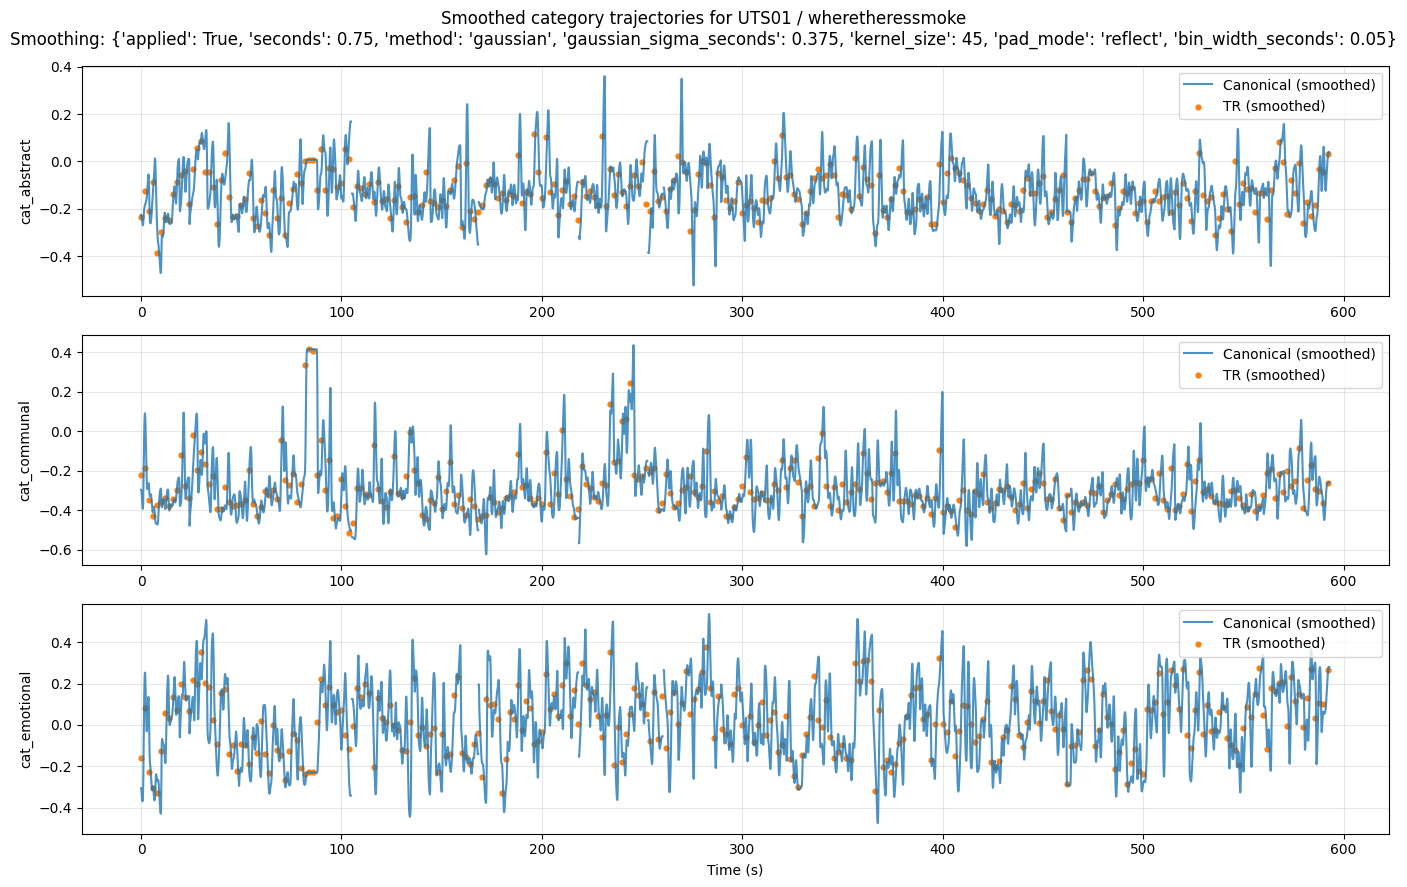

In [6]:
# Visualize canonical vs TR series for selected categories
if plt is None:
    raise RuntimeError('Matplotlib not available in this environment.')

category_cols = [col for col in tr_df.columns if col.startswith('cat_')]
if not category_cols:
    raise ValueError('No category columns found – ensure the pipeline cell executed successfully.')

if widgets is not None:
    selector = widgets.SelectMultiple(
        options=category_cols,
        value=tuple(category_cols[: min(3, len(category_cols))]),
        description='Categories',
        layout=widgets.Layout(width='50%')
    )
    display(selector)
    selected = list(selector.value) or category_cols[: min(3, len(category_cols))]
else:
    selected = category_cols[: min(3, len(category_cols))]

canonical_time = 0.5 * (result['canonical_edges'][:-1] + result['canonical_edges'][1:])
tr_time = result['tr_edges'][:-1]

fig, axes = plt.subplots(len(selected), 1, figsize=(14, 3 * len(selected)), sharex=False)
if len(selected) == 1:
    axes = [axes]

for ax, cat in zip(axes, selected):
    ax.plot(canonical_time, canonical_df[cat], label='Canonical (smoothed)', color='tab:blue', alpha=0.8)
    ax.scatter(tr_time, tr_df[cat], label='TR (smoothed)', color='tab:orange', s=12)
    ax.set_ylabel(cat)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Time (s)')
fig.suptitle(f"Smoothed category trajectories for {SUBJECT} / {STORY}\nSmoothing: {result['smoothing']}")
plt.tight_layout()
plt.show()



SelectMultiple(description='Categories', index=(0, 1, 2), layout=Layout(width='50%'), options=('cat_abstract',…

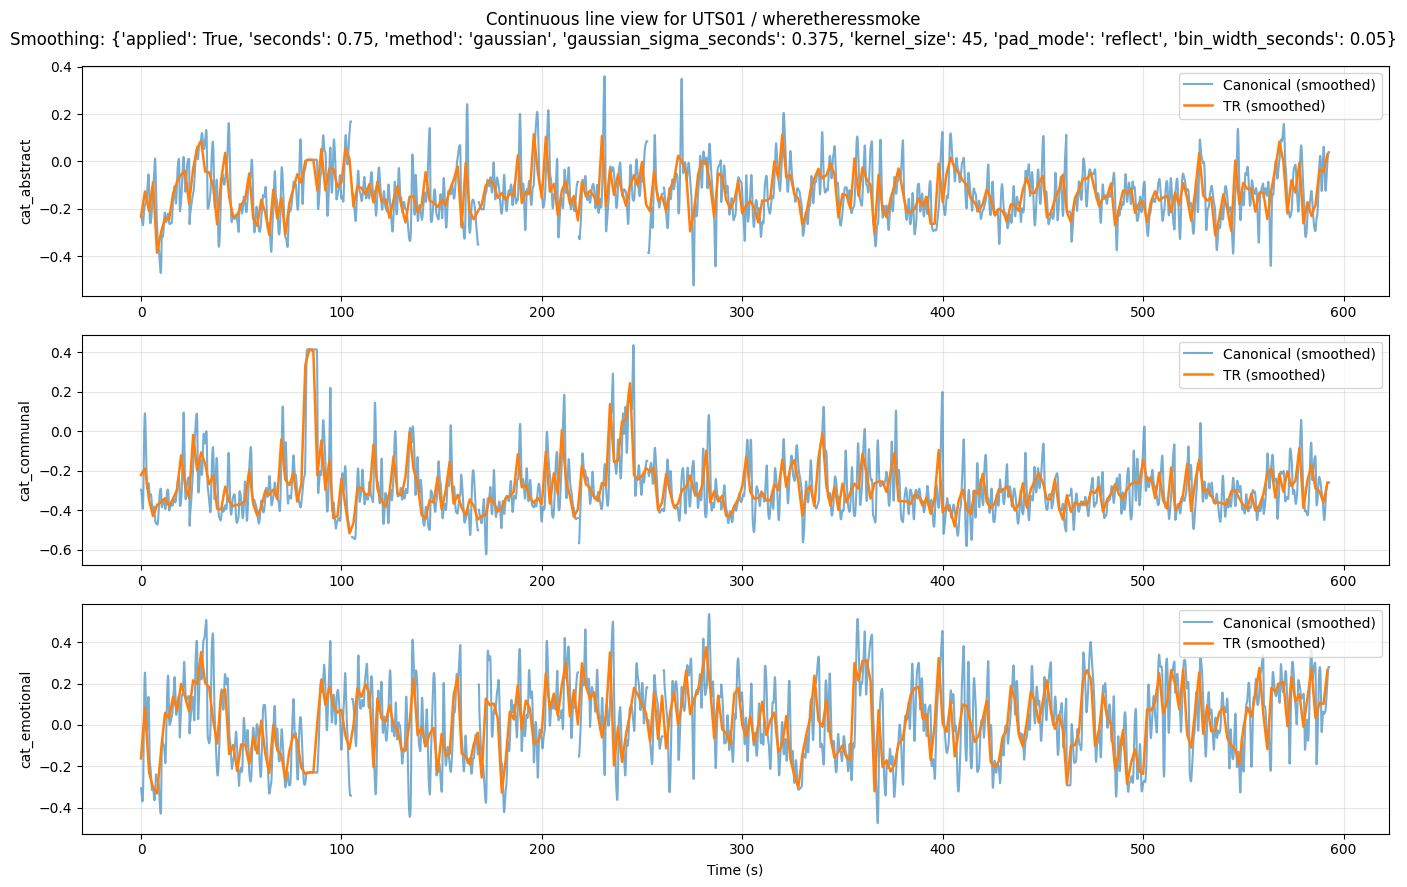

In [7]:
# Continuous line view of canonical and TR series
if plt is None:
    raise RuntimeError('Matplotlib not available in this environment.')

if 'result' not in globals():
    raise RuntimeError('Run the generation cell first to populate `result`.')

tr_line_df = result['category_df_selected']
canonical_line_df = result['canonical_df_selected']
category_cols = [col for col in tr_line_df.columns if col.startswith('cat_')]
if not category_cols:
    raise ValueError('No category columns available for plotting.')

if widgets is not None:
    selector = widgets.SelectMultiple(
        options=category_cols,
        value=tuple(category_cols[: min(3, len(category_cols))]),
        description='Categories',
        layout=widgets.Layout(width='50%')
    )
    display(selector)
    selected = list(selector.value) or category_cols[: min(3, len(category_cols))]
else:
    selected = category_cols[: min(3, len(category_cols))]

canonical_time = 0.5 * (result['canonical_edges'][:-1] + result['canonical_edges'][1:])
tr_time = result['tr_edges'][:-1]

fig, axes = plt.subplots(len(selected), 1, figsize=(14, 3 * len(selected)), sharex=False)
if len(selected) == 1:
    axes = [axes]

for ax, cat in zip(axes, selected):
    ax.plot(canonical_time, canonical_line_df[cat], label='Canonical (smoothed)', color='tab:blue', alpha=0.6)
    ax.plot(tr_time, tr_line_df[cat], label='TR (smoothed)', color='tab:orange', linewidth=1.8)
    ax.set_ylabel(cat)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Time (s)')
fig.suptitle(f"Continuous line view for {SUBJECT} / {STORY}\nSmoothing: {result['smoothing']}")
plt.tight_layout()
plt.show()



In [8]:
# Prepare transcript tokens and per-category scores
import numpy as np
import pandas as pd

if 'result' not in globals():
    raise RuntimeError('Run the generation cell first to populate `result`.')

_tokens_raw = result.get('event_records') or []
if not _tokens_raw:
    raise RuntimeError('No transcript events found — rerun upstream steps.')

_category_states = result.get('category_states') or {}
if not _category_states:
    raise RuntimeError('Category states missing from result; rerun the generation cell.')

_token_df = pd.DataFrame(_tokens_raw)
_token_df = _token_df[['word', 'start', 'end', 'embedding', 'embedding_norm']].copy()
_token_df['midpoint'] = 0.5 * (_token_df['start'] + _token_df['end'])
_token_df['duration'] = _token_df['end'] - _token_df['start']
_token_df['token_index'] = np.arange(len(_token_df))

_score_method = str(result.get('category_score_method', 'similarity')).lower()
_token_scores = {}
_abs_max = 0.0
for cat_name, state in _category_states.items():
    scores = []
    proto = state.get('prototype')
    proto_norm = state.get('prototype_norm') or 0.0
    lexicon = state.get('lexicon', {}) or {}
    for rec in _tokens_raw:
        word = rec['word']
        if _score_method == 'count':
            score = lexicon.get(word.lower(), np.nan)
        else:
            emb = rec.get('embedding')
            emb_norm = rec.get('embedding_norm') or 0.0
            if emb is None or proto is None or proto_norm <= 0 or emb_norm <= 0:
                score = np.nan
            else:
                score = float(np.clip(np.dot(emb, proto) / (emb_norm * proto_norm), -1.0, 1.0))
        scores.append(score)
    arr = np.array(scores, dtype=float)
    _token_scores[cat_name] = arr
    finite = np.abs(arr[np.isfinite(arr)])
    if finite.size:
        _abs_max = max(_abs_max, float(finite.max()))

TOKEN_BASE_DF = _token_df[['token_index', 'word', 'start', 'end', 'midpoint', 'duration']].copy()
TOKEN_SCORE_CACHE = _token_scores
TOKEN_SCORE_METHOD = _score_method
TOKEN_SCORE_ABS_MAX = _abs_max if _abs_max > 0 else 1.0

# Drop heavy objects from the temporary frame to free memory
del _token_df
del _tokens_raw


In [9]:
# Transcript-category alignment explorer
import numpy as np
import pandas as pd
import matplotlib.lines as mlines

if 'TOKEN_BASE_DF' not in globals():
    raise RuntimeError('Run the token-prep cell before using the alignment explorer.')

category_cols = result['category_columns']
if not category_cols:
    raise RuntimeError('No category columns available for alignment view.')

canonical_time = 0.5 * (result['canonical_edges'][:-1] + result['canonical_edges'][1:])
tr_time = result['tr_edges'][:-1]
canonical_df_full = result['canonical_df_selected']
tr_df_full = result['category_df_selected']

_category_name_lookup = {col: (col[4:] if col.startswith('cat_') else col) for col in category_cols}
MAX_TOKENS_DISPLAY = 60
FOCUS_WINDOW_SECONDS = 20.0


def _interpolate_series(series_values: pd.Series, times: np.ndarray, query: np.ndarray) -> np.ndarray:
    values = np.asarray(series_values, dtype=float)
    times = np.asarray(times, dtype=float)
    query = np.asarray(query, dtype=float)
    finite = np.isfinite(values)
    if finite.sum() < 2:
        return np.full(query.shape, np.nan, dtype=float)
    interp = np.interp(query, times[finite], values[finite])
    interp[(query < times[finite][0]) | (query > times[finite][-1])] = np.nan
    return interp


def _prepare_subset(cat_col: str, cat_name: str, t0: float, t1: float) -> pd.DataFrame:
    mask = (TOKEN_BASE_DF['midpoint'] >= t0) & (TOKEN_BASE_DF['midpoint'] <= t1)
    subset = TOKEN_BASE_DF.loc[mask].copy()
    scores = TOKEN_SCORE_CACHE.get(cat_name)
    if scores is None:
        raise RuntimeError(f'No cached scores for category {cat_name}')
    subset['score'] = scores[mask.to_numpy()]
    subset['abs_score'] = subset['score'].abs()
    subset.sort_values('start', inplace=True)
    subset['canonical_value'] = _interpolate_series(canonical_df_full[cat_col], canonical_time, subset['midpoint'].to_numpy())
    subset['tr_value'] = _interpolate_series(tr_df_full[cat_col], tr_time, subset['midpoint'].to_numpy())
    return subset


def _plot_alignment(cat_col: str, subset: pd.DataFrame, highlight: pd.DataFrame, *, t0: float, t1: float, min_similarity: float):
    highlight_ranked = highlight.sort_values('score', ascending=False)
    if len(highlight_ranked) > MAX_TOKENS_DISPLAY:
        plot_highlight = highlight_ranked.head(MAX_TOKENS_DISPLAY).sort_values('midpoint')
    else:
        plot_highlight = highlight_ranked.sort_values('midpoint')

    series_canon = canonical_df_full[cat_col].to_numpy(dtype=float)
    series_tr = tr_df_full[cat_col].to_numpy(dtype=float)
    max_abs = float(np.nanmax(np.abs(subset['score'].to_numpy()))) if subset['score'].notna().any() else 1.0
    max_abs = max(max_abs, 1.0)

    fig = plt.figure(figsize=(14, 5))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.12)
    ax = fig.add_subplot(gs[0])
    ax_tokens = fig.add_subplot(gs[1], sharex=ax)

    canon_mask = (canonical_time >= t0) & (canonical_time <= t1)
    tr_mask = (tr_time >= t0) & (tr_time <= t1)
    ax.plot(canonical_time[canon_mask], series_canon[canon_mask], color='tab:blue', label='Canonical (smoothed)')
    ax.plot(tr_time[tr_mask], series_tr[tr_mask], color='tab:orange', label='TR (smoothed)')

    token_handle = None
    if not plot_highlight.empty:
        scale = float(np.nanmax(plot_highlight['abs_score'].to_numpy())) if plot_highlight['abs_score'].notna().any() else 0.0
        scale = scale if scale > 0 else 1.0
        colors = np.where(plot_highlight['score'] >= 0, 'tab:green', 'tab:red')
        sizes = 60 + 200 * (plot_highlight['abs_score'] / scale)
        ax.scatter(plot_highlight['midpoint'], plot_highlight['canonical_value'], s=sizes, c=colors, alpha=0.9, edgecolor='white', linewidth=0.4)
        token_handle = mlines.Line2D([], [], marker='o', linestyle='None', color='tab:green', markerfacecolor='tab:green', markeredgecolor='white', label='Transcript tokens')

        ax_tokens.axhline(0.0, color='0.6', linewidth=1.0)
        ax_tokens.vlines(plot_highlight['midpoint'], 0.0, plot_highlight['score'], colors=colors, linewidth=2.0, alpha=0.8)
        for row in plot_highlight.itertuples():
            y = row.score
            offset = 0.04 * max_abs
            text_y = y + offset if y >= 0 else y - offset
            va = 'bottom' if y >= 0 else 'top'
            ax_tokens.text(row.midpoint, text_y, row.word, rotation=90, ha='center', va=va, fontsize=8)
        ax_tokens.set_ylim(-max_abs * 1.3, max_abs * 1.3)
    else:
        ax_tokens.axhline(0.0, color='0.6', linewidth=1.0)
        ax_tokens.text(0.5, 0.5, 'No tokens matched the current filters', transform=ax_tokens.transAxes, ha='center', va='center', fontsize=10, color='0.4')
        ax_tokens.set_ylim(-1.0, 1.0)

    ax.set_xlim(t0, t1)
    ax.grid(True, alpha=0.3)
    ax.set_ylabel(cat_col)
    ax.set_title(f'{cat_col} | window {t0:.1f}–{t1:.1f} s', loc='left', fontsize=11)
    handles, labels = ax.get_legend_handles_labels()
    if token_handle is not None:
        handles.append(token_handle)
        labels.append('Transcript tokens')
    ax.legend(handles, labels, loc='upper right')
    plt.setp(ax.get_xticklabels(), visible=False)

    ax_tokens.set_xlim(t0, t1)
    ax_tokens.set_xlabel('Time (s)')
    ax_tokens.set_ylabel('Token score')
    ax_tokens.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    display_columns = ['word', 'start', 'end', 'duration', 'score', 'canonical_value', 'tr_value']
    if not highlight_ranked.empty:
        display_df = highlight_ranked[display_columns].head(MAX_TOKENS_DISPLAY).reset_index(drop=True)
        if len(highlight_ranked) > MAX_TOKENS_DISPLAY:
            print(f'Showing top {MAX_TOKENS_DISPLAY} of {len(highlight_ranked)} tokens (sorted by similarity score).')
    else:
        display_df = subset[display_columns].head(MAX_TOKENS_DISPLAY).reset_index(drop=True)
        if len(subset) > MAX_TOKENS_DISPLAY:
            print('No tokens matched the current filters; showing first tokens in window.')
    display(display_df)


if widgets is not None:
    cat_dropdown = widgets.Dropdown(options=category_cols, description='Category:', layout=widgets.Layout(width='35%'))
    window_slider = widgets.FloatRangeSlider(
        value=(0.0, min(120.0, float(canonical_time[-1]))),
        min=0.0,
        max=float(canonical_time[-1]),
        step=1.0,
        description='Time window (s):',
        layout=widgets.Layout(width='70%')
    )
    threshold_slider = widgets.FloatSlider(
        value=min(0.05, TOKEN_SCORE_ABS_MAX),
        min=0.0,
        max=max(0.1, TOKEN_SCORE_ABS_MAX),
        step=0.01,
        readout_format='.2f',
        description='|score| ≥',
        layout=widgets.Layout(width='50%')
    )
    similarity_slider = widgets.FloatSlider(
        value=-1.0,
        min=-1.0,
        max=1.0,
        step=0.01,
        readout_format='.2f',
        description='score ≥',
        layout=widgets.Layout(width='50%')
    )
    focus_peak_btn = widgets.Button(description='Focus on peak', icon='arrow-up')
    focus_trough_btn = widgets.Button(description='Focus on trough', icon='arrow-down')

    display(cat_dropdown, window_slider, widgets.HBox([threshold_slider, similarity_slider]), widgets.HBox([focus_peak_btn, focus_trough_btn]))
    out = widgets.Output()
    display(out)

    def _update_alignment(*_):
        with out:
            out.clear_output()
            cat_col = cat_dropdown.value
            cat_name = _category_name_lookup[cat_col]
            t0, t1 = window_slider.value
            min_abs = float(threshold_slider.value)
            min_similarity = float(similarity_slider.value)

            subset = _prepare_subset(cat_col, cat_name, t0, t1)
            highlight = subset[subset['abs_score'] >= min_abs].copy()
            if min_similarity > similarity_slider.min + 1e-9:
                highlight = highlight[highlight['score'] >= min_similarity]
            _plot_alignment(cat_col, subset, highlight, t0=t0, t1=t1, min_similarity=min_similarity)

    def _focus_window(extreme: str):
        cat_col = cat_dropdown.value
        cat_name = _category_name_lookup[cat_col]
        scores = TOKEN_SCORE_CACHE.get(cat_name)
        if scores is None:
            return
        base = TOKEN_BASE_DF.copy()
        base['score'] = scores
        base = base[np.isfinite(base['score'])]
        if base.empty:
            return
        idx = base['score'].idxmax() if extreme == 'high' else base['score'].idxmin()
        center = float(base.loc[idx, 'midpoint'])
        half = 0.5 * FOCUS_WINDOW_SECONDS
        t0 = max(window_slider.min, center - half)
        t1 = min(window_slider.max, center + half)
        target_value = float(base.loc[idx, 'score'])
        target_abs = abs(target_value)
        window_slider.value = (t0, t1)
        if target_abs > 0:
            new_threshold = min(threshold_slider.max, max(threshold_slider.min, target_abs * 0.6))
            threshold_slider.value = new_threshold
        if similarity_slider.value > target_value:
            similarity_slider.value = max(similarity_slider.min, target_value)
        _update_alignment()

    focus_peak_btn.on_click(lambda _: _focus_window('high'))
    focus_trough_btn.on_click(lambda _: _focus_window('low'))

    _update_alignment()
    for widget in (cat_dropdown, window_slider, threshold_slider, similarity_slider):
        widget.observe(_update_alignment, 'value')
else:
    raise RuntimeError('ipywidgets unavailable; run in an interactive notebook environment for alignment explorer.')


Dropdown(description='Category:', layout=Layout(width='35%'), options=('cat_abstract', 'cat_communal', 'cat_em…

FloatRangeSlider(value=(0.0, 120.0), description='Time window (s):', layout=Layout(width='70%'), max=601.925, …

Output()

## Next steps

- Use `result['category_df_selected']` (or the trimmed slice if available) as the predictor matrix for EDM/Simplex/CCM. These columns are already TR-aligned and smoothed.
- If you need the unsmoothed counterpart, refer to `result['category_df_raw']` and the saved `category_timeseries_raw.csv` (when `SAVE_OUTPUTS=True`).
- Adjust `SMOOTHING_SECONDS` / `SMOOTHING_METHOD` and rerun the pipeline cell to explore different low-pass settings before modelling.
